In [1]:
# Import packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from timeit import default_timer as timer

from sklearn.pipeline import Pipeline 
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, RobustScaler
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.model_selection import cross_val_predict, cross_val_score, cross_validate
from sklearn.metrics import  mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor

# import functions
from src.modeling.modeling_functions import error_analysis

pd.set_option('display.float_format', lambda x: '%.2f' % x) # change decimal places

RSEED = 42

## Loading the processed dataframe (sugarbeet and openweather station data - all fields)

In [10]:
df = pd.read_pickle('pickles/df_openweather_monthly_sugarbeet.pkl')
df

,station_location,dew_point_monthly_10,dew_point_monthly_4,dew_point_monthly_5,dew_point_monthly_6,dew_point_monthly_7,dew_point_monthly_8,dew_point_monthly_9,humidity_monthly_10,humidity_monthly_4,...,ms_comp,obj,otype_comp,sc_nir,seednames_coded,seriesid,totaln_nir,x,y,pollinator
0,Anklam,7.81,3.44,7.72,12.13,13.88,13.99,11.19,86.31,74.09,...,2.00,10.00,1.00,17.20,108.00,1503.00,0.15,96.00,13.00,6.00
1,Anklam,7.81,3.44,7.72,12.13,13.88,13.99,11.19,86.31,74.09,...,2.00,14.00,1.00,17.68,1191.00,1503.00,0.16,96.00,14.00,16.00
2,Anklam,7.81,3.44,7.72,12.13,13.88,13.99,11.19,86.31,74.09,...,2.00,13.00,1.00,17.37,103.00,1503.00,0.16,96.00,15.00,10.00
3,Anklam,7.81,3.44,7.72,12.13,13.88,13.99,11.19,86.31,74.09,...,2.00,9.00,1.00,16.91,107.00,1503.00,0.15,96.00,16.00,6.00
4,Anklam,7.81,3.44,7.72,12.13,13.88,13.99,11.19,86.31,74.09,...,2.00,17.00,1.00,17.20,1194.00,1503.00,0.15,97.00,13.00,17.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14423,Vierhoefen,4.82,4.07,8.63,12.17,13.25,13.00,9.60,76.70,67.98,...,1.00,50.00,3.00,14.53,628.00,1516.00,0.16,83.00,8.00,102.00
14424,Vierhoefen,4.82,4.07,8.63,12.17,13.25,13.00,9.60,76.70,67.98,...,7.00,4.00,8.00,13.70,1205.00,1516.00,0.16,83.00,9.00,113.00
14425,Vierhoefen,4.82,4.07,8.63,12.17,13.25,13.00,9.60,76.70,67.98,...,1.00,33.00,3.00,12.91,466.00,1516.00,0.14,83.00,10.00,80.00
14426,Vierhoefen,4.82,4.07,8.63,12.17,13.25,13.00,9.60,76.70,67.98,...,1.00,51.00,3.00,13.44,629.00,1516.00,0.13,83.00,11.00,102.00


In [11]:
# convert to string for categorizing
df['seednames_coded'] = df['seednames_coded'].astype(str)
df['pollinator_comp'] = df['pollinator_comp'].astype(str)
df['ms_comp'] = df['ms_comp'].astype(str)
df['otype_comp'] = df['otype_comp'].astype(str)

In [12]:
df.shape

(14427, 74)

In [13]:
# dropping columns 
df.drop(['betaine_nir', 
         'cry_nir', 
         'dm_nir', 
         'invert_nir', 
         'mark_nir', 
         #'sc_nir',
         'csy_nir', 
         'totaln_nir', 
         'obj',  
         'seriesid', 
         'x', 
         'y', 
         'ms_comp',
         'otype_comp', 
         #'pollinator_comp',
         #'seednames_coded',
         'region',
         'station_location'
         ], axis=1, inplace=True)
df.columns

Index(['dew_point_monthly_10', 'dew_point_monthly_4', 'dew_point_monthly_5',
       'dew_point_monthly_6', 'dew_point_monthly_7', 'dew_point_monthly_8',
       'dew_point_monthly_9', 'humidity_monthly_10', 'humidity_monthly_4',
       'humidity_monthly_5', 'humidity_monthly_6', 'humidity_monthly_7',
       'humidity_monthly_8', 'humidity_monthly_9', 'pressure_monthly_10',
       'pressure_monthly_4', 'pressure_monthly_5', 'pressure_monthly_6',
       'pressure_monthly_7', 'pressure_monthly_8', 'pressure_monthly_9',
       'temp_max_monthly_10', 'temp_max_monthly_4', 'temp_max_monthly_5',
       'temp_max_monthly_6', 'temp_max_monthly_7', 'temp_max_monthly_8',
       'temp_max_monthly_9', 'temp_min_monthly_10', 'temp_min_monthly_4',
       'temp_min_monthly_5', 'temp_min_monthly_6', 'temp_min_monthly_7',
       'temp_min_monthly_8', 'temp_min_monthly_9', 'temp_monthly_10',
       'temp_monthly_4', 'temp_monthly_5', 'temp_monthly_6', 'temp_monthly_7',
       'temp_monthly_8', 'temp_month

In [14]:
df.shape

(14427, 59)

In [15]:
# reset index after drpping columns
df = df.reset_index(drop=True)

#### Creating the pipeline

In [16]:
# creating list for categorical predictors/features 
cat_features = list(df.columns[df.dtypes==object])
cat_features

['seednames_coded', 'pollinator']

In [17]:
# creating list for numerical predictors/features
# since 'sc_nir' is our target variable we will exclude this feature from the list of numerical predictors 
# latitude and longitude are also excluded to avoid location influence on prediction
num_features = [
 'dew_point_monthly_10.0',
 'dew_point_monthly_4.0',
 'dew_point_monthly_5.0',
 'dew_point_monthly_6.0',
 'dew_point_monthly_7.0',
 'dew_point_monthly_8.0',
 'dew_point_monthly_9.0',
 'humidity_monthly_10.0',
 'humidity_monthly_4.0',
 'humidity_monthly_5.0',
 'humidity_monthly_6.0',
 'humidity_monthly_7.0',
 'humidity_monthly_8.0',
 'humidity_monthly_9.0',
 'pressure_monthly_10.0',
 'pressure_monthly_4.0',
 'pressure_monthly_5.0',
 'pressure_monthly_6.0',
 'pressure_monthly_7.0',
 'pressure_monthly_8.0',
 'pressure_monthly_9.0',
 'temp_max_monthly_10.0',
 'temp_max_monthly_4.0',
 'temp_max_monthly_5.0',
 'temp_max_monthly_6.0',
 'temp_max_monthly_7.0',
 'temp_max_monthly_8.0',
 'temp_max_monthly_9.0',
 'temp_min_monthly_10.0',
 'temp_min_monthly_4.0',
 'temp_min_monthly_5.0',
 'temp_min_monthly_6.0',
 'temp_min_monthly_7.0',
 'temp_min_monthly_8.0',
 'temp_min_monthly_9.0',
 'temp_monthly_10.0',
 'temp_monthly_4.0',
 'temp_monthly_5.0',
 'temp_monthly_6.0',
 'temp_monthly_7.0',
 'temp_monthly_8.0',
 'temp_monthly_9.0',
 'wind_deg_monthly_10.0',
 'wind_deg_monthly_4.0',
 'wind_deg_monthly_5.0',
 'wind_deg_monthly_6.0',
 'wind_deg_monthly_7.0',
 'wind_deg_monthly_8.0',
 'wind_deg_monthly_9.0',
 'wind_speed_monthly_10.0',
 'wind_speed_monthly_4.0',
 'wind_speed_monthly_5.0',
 'wind_speed_monthly_6.0',
 'wind_speed_monthly_7.0',
 'wind_speed_monthly_8.0',
 'wind_speed_monthly_9.0'
]
num_features

['dew_point_monthly_10',
 'dew_point_monthly_4',
 'dew_point_monthly_5',
 'dew_point_monthly_6',
 'dew_point_monthly_7',
 'dew_point_monthly_8',
 'dew_point_monthly_9',
 'humidity_monthly_10',
 'humidity_monthly_4',
 'humidity_monthly_5',
 'humidity_monthly_6',
 'humidity_monthly_7',
 'humidity_monthly_8',
 'humidity_monthly_9',
 'pressure_monthly_10',
 'pressure_monthly_4',
 'pressure_monthly_5',
 'pressure_monthly_6',
 'pressure_monthly_7',
 'pressure_monthly_8',
 'pressure_monthly_9',
 'temp_max_monthly_10',
 'temp_max_monthly_4',
 'temp_max_monthly_5',
 'temp_max_monthly_6',
 'temp_max_monthly_7',
 'temp_max_monthly_8',
 'temp_max_monthly_9',
 'temp_min_monthly_10',
 'temp_min_monthly_4',
 'temp_min_monthly_5',
 'temp_min_monthly_6',
 'temp_min_monthly_7',
 'temp_min_monthly_8',
 'temp_min_monthly_9',
 'temp_monthly_10',
 'temp_monthly_4',
 'temp_monthly_5',
 'temp_monthly_6',
 'temp_monthly_7',
 'temp_monthly_8',
 'temp_monthly_9',
 'wind_deg_monthly_10',
 'wind_deg_monthly_4',
 '

#### Train-Test-Split

In [18]:
# define predictors and target variable
X = df.drop('sc_nir', axis=1)
y = df['sc_nir']
print(f"We have {X.shape[0]} observations in our dataset and {X.shape[1]} features")
print(f"Our target vector has also {y.shape[0]} values")

We have 14427 observations in our dataset and 58 features
Our target vector has also 14427 values


In [19]:
# split into train and test set (train set: 70%, test set: 30%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=RSEED) 

In [20]:
print('X_train shape:', X_train.shape)
print('X_test shape:', X_test.shape)
print('y_train shape:', y_train.shape)
print('y_test shape:', y_test.shape)

X_train shape: (10098, 58)
X_test shape: (4329, 58)
y_train shape: (10098,)
y_test shape: (4329,)


#### Preprocessing Pipeline

In [21]:
# Pipeline for categorical features 
cat_pipeline = Pipeline([
    ('1hot', OneHotEncoder(handle_unknown='ignore'))
])

In [22]:
# Pipeline for numerical features
num_pipeline = Pipeline([
    ('std_scaler', RobustScaler())
])

In [23]:
# complete pipeline for numerical features
# apply transformers to numerical pipeline
preprocessor = ColumnTransformer([
    ('num', num_pipeline, num_features),
    ('cat', cat_pipeline, cat_features)
])

### Predictive modeling using Pipeline and GridSearch

#### Random Forest

In [24]:
# building a full pipeline with our preprocessor and the RandomForestRegressor
pipe = Pipeline([
    ('preprocessor', preprocessor),
    ('randomforest', RandomForestRegressor())
])

In [25]:
# making predictions on the training set using cross validation as well as calculating the probabilities
# cross_val_predict expects an estimator (model), X, y and number of cv-splits (cv)
y_train_predicted = cross_val_predict(pipe, X_train, y_train, cv=5)

In [26]:
# Mean Squared Error
print('MSE Random Forest Train:\n', mean_squared_error(y_train, y_train_predicted))

# Root Mean Squared Error
print('RMSE Random Forest Train:\n', mean_squared_error(y_train, y_train_predicted, squared = False))

# R^2 Score
print('R^2 Random Forest Train:\n', r2_score(y_train, y_train_predicted))


MSE Random Forest Train:
 0.36135102590082874
RMSE Random Forest Train:
 0.6011248006036922
R^2 Random Forest Train:
 0.872380646395502


#### Optimizing via GridSearch

In [27]:
# defining parameter space for grid-search
# add 'randomforest__' infront of the corresponding hyperparameters
param = {'randomforest__max_depth': [10,20,30,40,50],
                  'randomforest__max_features': ["sqrt"],
                  'randomforest__max_leaf_nodes': [500, 5000],
                  'randomforest__min_samples_split': [10, 50, 100]}

grid = GridSearchCV(pipe, param_grid=param, scoring = r2_score, cv=5,
                           verbose=1, n_jobs=-1)

In [28]:
# train the model
grid.fit(X_train, y_train)

Fitting 5 folds for each of 30 candidates, totalling 150 fits


/Users/isabellecarinaflaig/neuefische/capstone_project/.venv/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/isabellecarinaflaig/neuefische/capstone_project/.venv/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
TypeError: r2_score() takes 2 positional arguments but 3 were given

  warnings.warn(
/Users/isabellecarinaflaig/neuefische/capstone_project/.venv/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/isabellecarinaflaig/neuefische/capstone_project/.venv/lib/python3.9/site-packages/sklearn/model_selection/_validation.py

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('std_scaler',
                                                                                          RobustScaler())]),
                                                                         ['dew_point_monthly_10',
                                                                          'dew_point_monthly_4',
                                                                          'dew_point_monthly_5',
                                                                          'dew_point_monthly_6',
                                                                          'dew_point_monthly_7',
                                                                          'dew_point_monthly_8',
                                                 

In [29]:
# show best parameters
print('Best score:\n{:.2f}'.format(grid.best_score_))
print("Best parameters:\n{}".format(grid.best_params_))

Best score:
nan
Best parameters:
{'randomforest__max_depth': 10, 'randomforest__max_features': 'sqrt', 'randomforest__max_leaf_nodes': 500, 'randomforest__min_samples_split': 10}


In [30]:
# save best model (including fitted preprocessing steps) as best_model 
best_model = grid.best_estimator_
best_model

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('std_scaler',
                                                                   RobustScaler())]),
                                                  ['dew_point_monthly_10',
                                                   'dew_point_monthly_4',
                                                   'dew_point_monthly_5',
                                                   'dew_point_monthly_6',
                                                   'dew_point_monthly_7',
                                                   'dew_point_monthly_8',
                                                   'dew_point_monthly_9',
                                                   'humidity_monthly_10',
                                                   'humidity_monthly_4',
                                                   'humidity_monthly_5',
    

In [31]:
# calculating the mean squared error, root mean squared error and r^2 score for the test set with the optimized model
y_test_predicted = best_model.predict(X_test)

# Mean Squared Error
print('MSE Random Forest Test:\n', mean_squared_error(y_test, y_test_predicted))

# Root Mean Squared Error
print('RMSE Random Forest Test:\n', mean_squared_error(y_test, y_test_predicted, squared = False))

# R^2 Score
print('R^2 Random Forest Test:\n', r2_score(y_test, y_test_predicted))

MSE Random Forest Test:
 0.4956376525521515
RMSE Random Forest Test:
 0.7040153780651041
R^2 Random Forest Test:
 0.8295523253201718


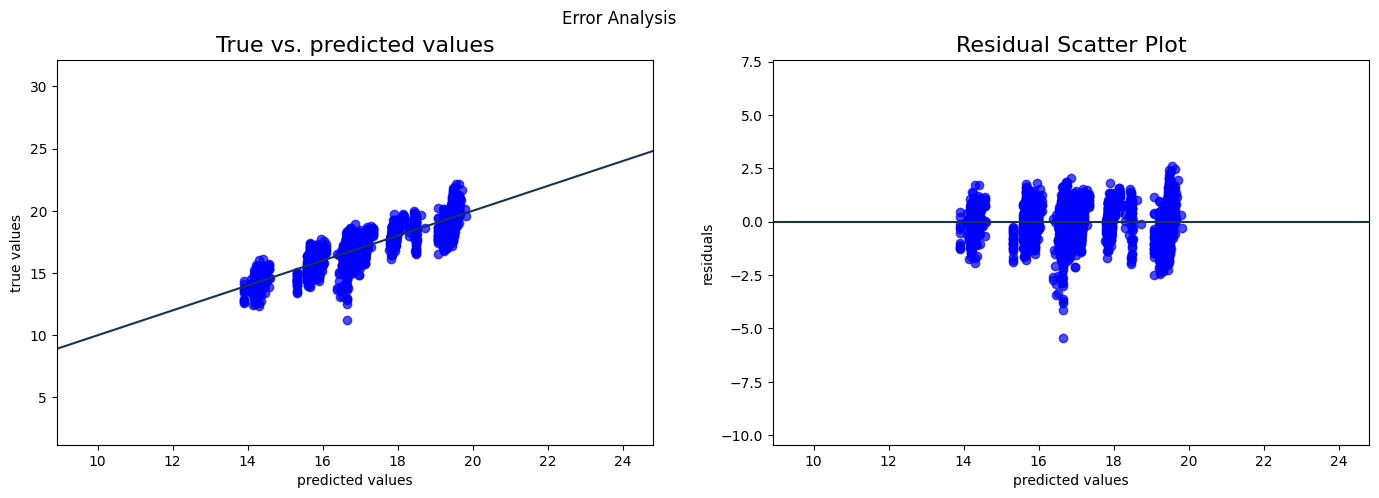

In [33]:
# evaluate the error
error_analysis(y_test,y_test_predicted)

#### Feature importance

In [34]:
# fit pipe with train data
model = pipe.fit(X_train, y_train)

In [35]:
# get coefficients
coefs = model.steps[1][1].feature_importances_

In [36]:
# get feature names
feature_names = model.steps[0][1].get_feature_names_out()

In [37]:
# zip coefficients and names together and make a DataFrame
zipped = zip(feature_names, coefs)
df = pd.DataFrame(zipped, columns=["feature", "value"])
# sort the features by the absolute value of their coefficient
df["abs_value"] = df["value"].apply(lambda x: abs(x))
df["colors"] = df["value"].apply(lambda x: "#2f7055"  if x > 0 else "red")
df = df.sort_values("abs_value", ascending=False)

Text(0.5, 0, 'Feature Name')

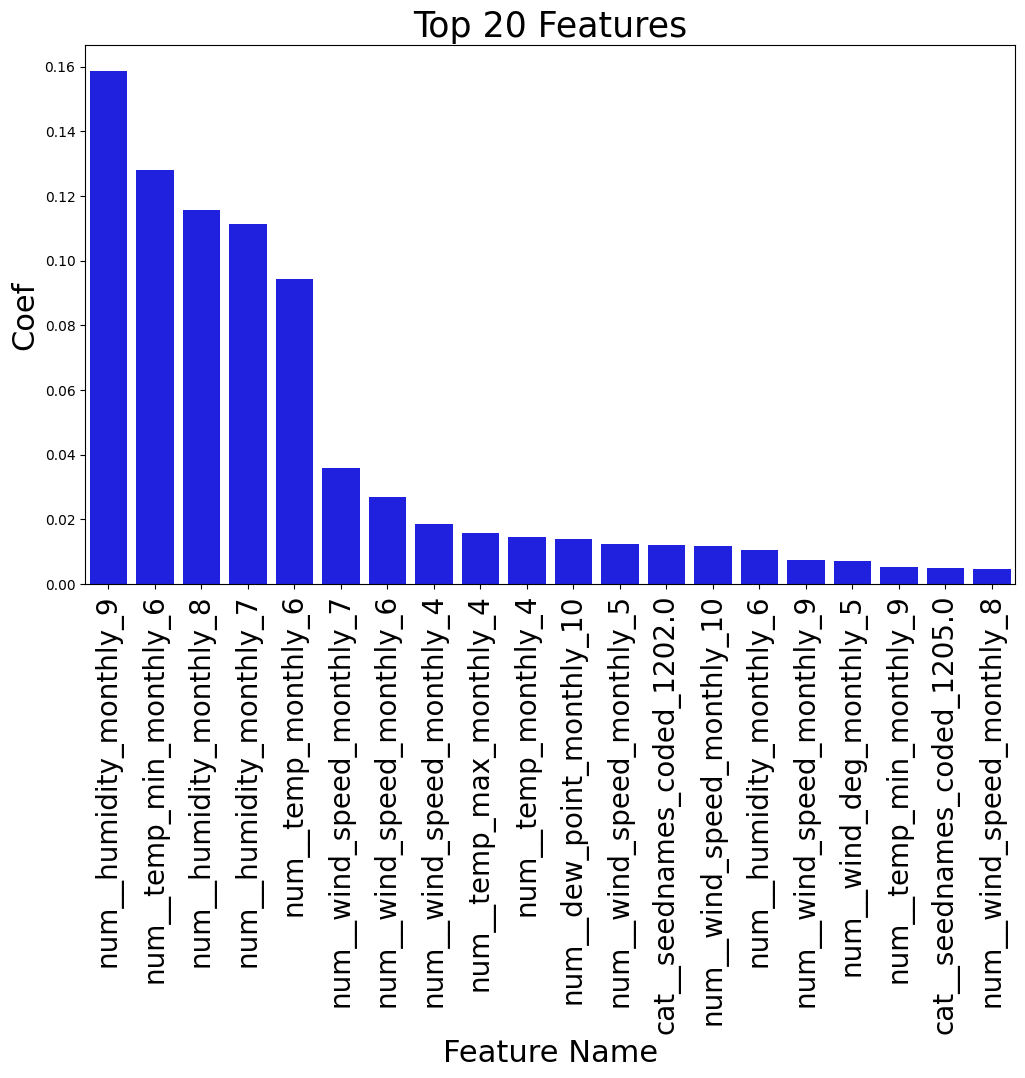

In [38]:
# plot feature importance
fig, ax = plt.subplots(1, 1, figsize=(12, 7))
sns.barplot(x="feature",
            y="value",
            data=df.head(20),
           palette=df.head(20)["colors"])
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, fontsize=20)
ax.set_title("Top 20 Features", fontsize=25)
ax.set_ylabel("Coef", fontsize=22)
ax.set_xlabel("Feature Name", fontsize=22)